In [1]:
import pyarrow.dataset as ds
from pyarrow import fs
import pandas as pd

s3 = fs.S3FileSystem()

dataset = ds.dataset(
    "chicagocrimedata-chalenge/data/chicago_crime_rank_database/chicago_crime_rank_parquet/",
    format="parquet",
    filesystem=s3,
    partitioning="hive"
)

In [2]:
df = dataset.to_table().to_pandas()
cached_df = df.copy()

In [3]:
df.sort_values("window_start", ascending=False)

,window_end,num_of_crimes,rank,community_area,window_start
12079,2022-12-31,4,77,9,2022-12-25
1412,2022-12-31,19,59,17,2022-12-25
11927,2022-12-31,149,2,8,2022-12-25
2668,2022-12-31,74,15,24,2022-12-25
5023,2022-12-31,62,21,38,2022-12-25
...,...,...,...,...,...
7376,2020-01-04,12,59,52,2019-12-29
5338,2020-01-04,21,44,40,2019-12-29
1099,2020-01-04,36,28,16,2019-12-29
11143,2020-01-04,6,73,74,2019-12-29


In [4]:
df.sort_values("window_start", ascending=False)

,window_end,num_of_crimes,rank,community_area,window_start
12079,2022-12-31,4,77,9,2022-12-25
1412,2022-12-31,19,59,17,2022-12-25
11927,2022-12-31,149,2,8,2022-12-25
2668,2022-12-31,74,15,24,2022-12-25
5023,2022-12-31,62,21,38,2022-12-25
...,...,...,...,...,...
7376,2020-01-04,12,59,52,2019-12-29
5338,2020-01-04,21,44,40,2019-12-29
1099,2020-01-04,36,28,16,2019-12-29
11143,2020-01-04,6,73,74,2019-12-29


In [5]:
# Convert 'window_end' and 'window_start' to datetime objects for easier manipulation
df['window_end'] = pd.to_datetime(df['window_end'])
df['window_start'] = pd.to_datetime(df['window_start'])

# Sort the dataset by 'community_area' and 'window_start' for rolling calculations
df.sort_values(by=['community_area', 'window_start'], inplace=True)

# Calculate historical averages for the past N windows
N = 2

# Calculate rolling average for 'num_of_crimes'
df['avg_num_of_crimes_last_N_weeks'] = df.groupby('community_area')['num_of_crimes'].transform(lambda x: x.shift(1).rolling(window=N).mean())

# Calculate rolling average for 'rank'
df['avg_rank_last_N_weeks'] = df.groupby('community_area')['rank'].transform(lambda x: x.shift(1).rolling(window=N).mean())

# Calculate rate of change for 'num_of_crimes'
df['rate_of_change_crimes'] = df.groupby('community_area')['num_of_crimes'].transform(lambda x: x.pct_change() * 100)

# Calculate rate of change for 'rank'
df['rate_of_change_rank'] = df.groupby('community_area')['rank'].transform(lambda x: x.pct_change() * 100)

# Drop NaN values generated by the rolling calculations and percentage change
df.dropna(inplace=True)

In [6]:
df.sort_values("window_start", ascending=False)

,window_end,num_of_crimes,rank,community_area,window_start,avg_num_of_crimes_last_N_weeks,avg_rank_last_N_weeks,rate_of_change_crimes,rate_of_change_rank
11770,2022-12-31,44,29,77,2022-12-25,47.0,34.5,29.411765,-29.268293
1412,2022-12-31,19,59,17,2022-12-25,29.0,48.5,-9.523810,11.320755
5965,2022-12-31,133,3,43,2022-12-25,128.5,4.5,7.258065,-25.000000
4866,2022-12-31,10,71,37,2022-12-25,11.0,71.5,25.000000,-4.054054
5180,2022-12-31,35,39,39,2022-12-25,47.0,36.0,-14.634146,11.428571
...,...,...,...,...,...,...,...,...,...
787,2020-01-18,33,46,14,2020-01-12,39.0,34.0,-34.000000,39.393939
10674,2020-01-18,142,6,71,2020-01-12,114.0,6.0,-3.401361,20.000000
11773,2020-01-18,175,2,8,2020-01-12,161.5,2.0,-7.407407,0.000000
9575,2020-01-18,39,41,65,2020-01-12,26.5,44.0,21.875000,-6.818182


In [7]:
!pip install xgboost

  Obtaining dependency information for xgboost from https://files.pythonhosted.org/packages/c1/cf/a662bc8f40588d54663edfe12980946670490bff0b6e793c7896a4fe36df/xgboost-2.0.0-py3-none-manylinux2014_x86_64.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 297.1/297.1 MB 882.7 kB/s eta 0:00:0000:0100:01


In [8]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Define features and target variable
X = df[['community_area', 'avg_num_of_crimes_last_N_weeks', 'rate_of_change_crimes']]
y = df['num_of_crimes']

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=20)

# Initialize and train the XGBoost model
model = xgb.XGBRegressor(n_estimators=1000, learning_rate=0.01, max_depth=4, random_state=47, objective='reg:squarederror')
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")
print(f"Mean Absolute Error: {mae}")


Mean Squared Error: 57.847125081985354
Mean Absolute Error: 4.587257189481468


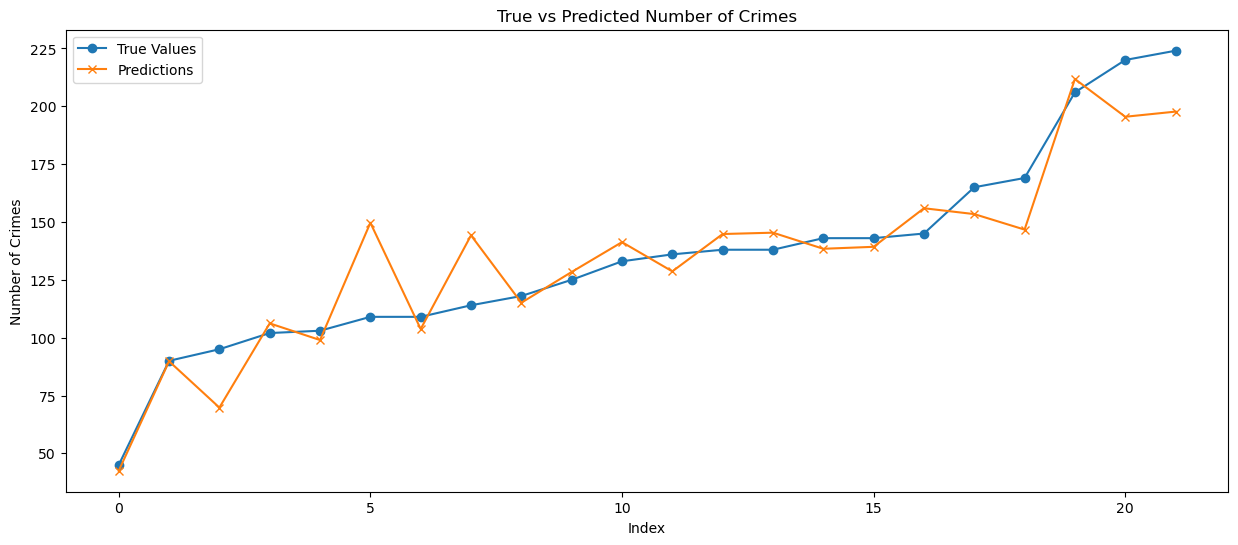

In [9]:
# Importing the required libraries for plotting
import matplotlib.pyplot as plt

# Create a DataFrame to hold the test results and predictions
result_df = X_test.copy()
result_df['True_num_of_crimes'] = y_test
result_df['Predicted_num_of_crimes'] = y_pred

# Sort the DataFrame for plotting
result_df.sort_values(by=['community_area', 'True_num_of_crimes'], inplace=True)

# Create a plot
plt.figure(figsize=(15, 6))

# You can also plot for a specific community_area by filtering result_df, for example:
community_area_to_plot = 28
df_to_plot = result_df[result_df['community_area'] == community_area_to_plot]

# Plotting all data for this example
plt.plot(df_to_plot['True_num_of_crimes'].reset_index(drop=True), label='True Values', marker='o')
plt.plot(df_to_plot['Predicted_num_of_crimes'].reset_index(drop=True), label='Predictions', marker='x')

plt.title('True vs Predicted Number of Crimes')
plt.xlabel('Index')
plt.ylabel('Number of Crimes')
plt.legend()
plt.show()

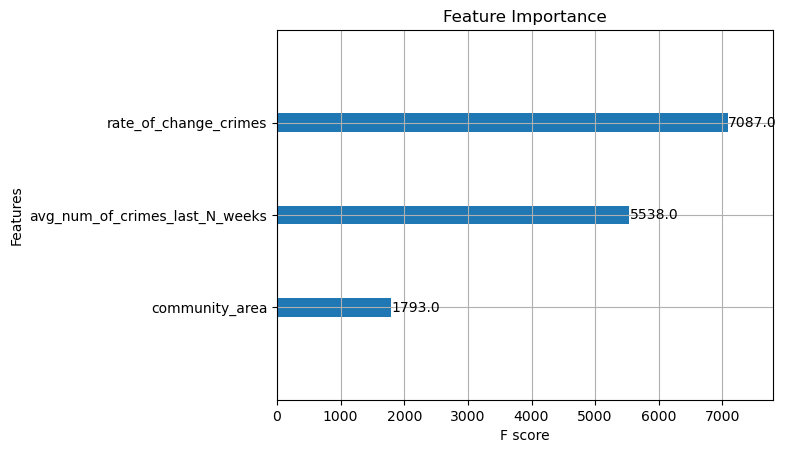

In [10]:
xgb.plot_importance(model)
plt.title("Feature Importance")
plt.show()

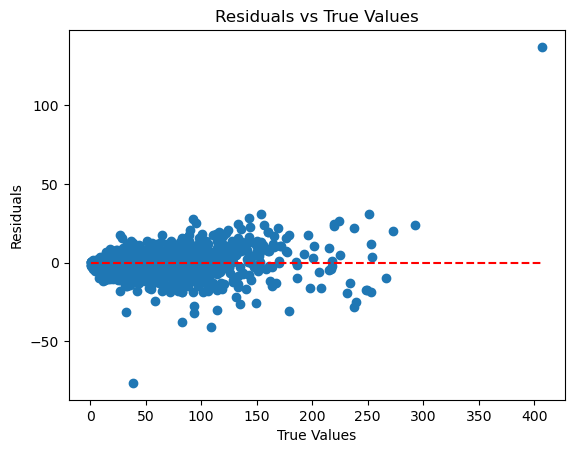

In [11]:
residuals = y_test - y_pred
plt.scatter(y_test, residuals)
plt.hlines(y=0, xmin=y_test.min(), xmax=y_test.max(), colors='r', linestyles='dashed')
plt.xlabel('True Values')
plt.ylabel('Residuals')
plt.title('Residuals vs True Values')
plt.show()

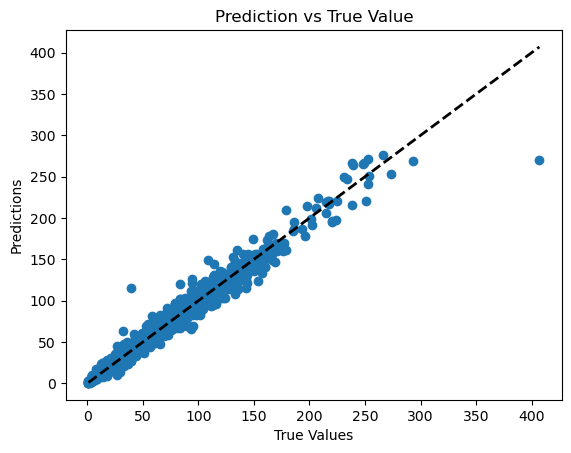

In [12]:
plt.scatter(y_test, y_pred)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.title('Prediction vs True Value')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.show()

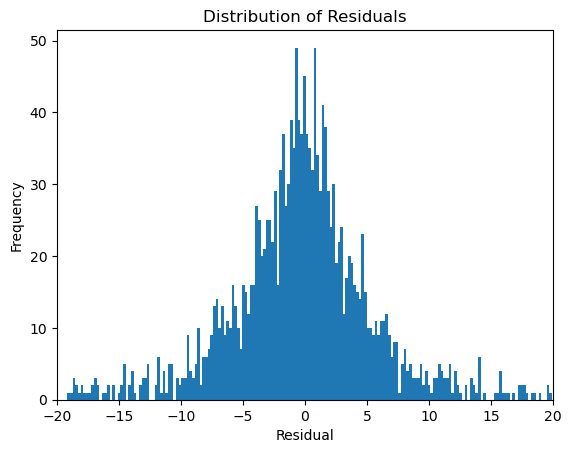

In [13]:
plt.hist(residuals, bins=1000)
plt.xlabel('Residual')
plt.ylabel('Frequency')
plt.title('Distribution of Residuals')
plt.xlim(-20, 20)
plt.show()

In [14]:
import pickle
import boto3

last_observed_data = df.groupby('community_area').last().reset_index()
second_last_observed_data = df.groupby('community_area').nth(-1).reset_index()

# Serialize the model
with open("xgboost_model.pkl", "wb") as f:
    pickle.dump({"model": model, "last_observed_data": last_observed_data.to_dict(), "second_last_observed_data": second_last_observed_data.to_dict()}, f)

s3 = boto3.client('s3')

# Specify the bucket name and the file name you want to save in S3
bucket_name = "chicagocrimedata-chalenge"
file_name = "ML/models/xgboost_model.pkl"

# Upload the model to S3
s3.upload_file("xgboost_model.pkl", bucket_name, file_name)

print(f"Model successfully uploaded to {bucket_name}/{file_name}")

Model successfully uploaded to chicagocrimedata-chalenge/ML/models/xgboost_model.pkl


In [15]:
last_observed_data

,community_area,window_end,num_of_crimes,rank,window_start,avg_num_of_crimes_last_N_weeks,avg_rank_last_N_weeks,rate_of_change_crimes,rate_of_change_rank
0,1,2022-12-31,63,20,2022-12-25,61.0,26.5,-3.076923,5.263158
1,2,2022-12-31,73,16,2022-12-25,61.0,25.0,55.319149,-46.666667
2,3,2022-12-31,41,32,2022-12-25,60.5,27.0,-35.937500,60.000000
3,4,2022-12-31,31,43,2022-12-25,42.0,39.0,-11.428571,7.500000
4,5,2022-12-31,24,55,2022-12-25,32.0,46.5,-11.111111,12.244898
...,...,...,...,...,...,...,...,...,...
72,73,2022-12-31,40,35,2022-12-25,50.0,34.0,-9.090909,9.375000
73,74,2022-12-31,9,73,2022-12-25,6.0,75.5,80.000000,-3.947368
74,75,2022-12-31,31,43,2022-12-25,34.0,44.5,-6.060606,0.000000
75,76,2022-12-31,25,53,2022-12-25,26.0,52.0,-10.714286,10.416667


In [16]:
s3.download_file(bucket_name, file_name, 'model_to_load.pkl')

with open('model_to_load.pkl', 'rb') as f:
    model = pickle.load(f)

In [17]:
from datetime import datetime, timedelta

last_observation = pd.DataFrame.from_dict(model["last_observed_data"])
second_last_observation = pd.DataFrame.from_dict(model["second_last_observed_data"])

# Get the last observation date; assuming 'window_end' is in datetime format
last_observation_date = last_observation['window_end'].max()

# Given future date in the format 'YYYY-MM-DD'
target_date = '2023-01-02'
target_date = datetime.strptime(target_date, '%Y-%m-%d')

# Calculate the number of days between the latest observation and the target date
days_to_target = (target_date - last_observation_date).days

# Calculate the number of weeks to forecast
num_weeks_to_forecast = days_to_target // 7  # Using integer division to get full weeks

# Check if there are extra days and add one week if so
if days_to_target % 7 > 0:
    num_weeks_to_forecast += 1

if days_to_target <= 1:
    num_weeks_to_forecast = 1


print(f"Number of weeks to forecast: {num_weeks_to_forecast}")
last_observation

Number of weeks to forecast: 1


,community_area,window_end,num_of_crimes,rank,window_start,avg_num_of_crimes_last_N_weeks,avg_rank_last_N_weeks,rate_of_change_crimes,rate_of_change_rank
0,1,2022-12-31,63,20,2022-12-25,61.0,26.5,-3.076923,5.263158
1,2,2022-12-31,73,16,2022-12-25,61.0,25.0,55.319149,-46.666667
2,3,2022-12-31,41,32,2022-12-25,60.5,27.0,-35.937500,60.000000
3,4,2022-12-31,31,43,2022-12-25,42.0,39.0,-11.428571,7.500000
4,5,2022-12-31,24,55,2022-12-25,32.0,46.5,-11.111111,12.244898
...,...,...,...,...,...,...,...,...,...
72,73,2022-12-31,40,35,2022-12-25,50.0,34.0,-9.090909,9.375000
73,74,2022-12-31,9,73,2022-12-25,6.0,75.5,80.000000,-3.947368
74,75,2022-12-31,31,43,2022-12-25,34.0,44.5,-6.060606,0.000000
75,76,2022-12-31,25,53,2022-12-25,26.0,52.0,-10.714286,10.416667


In [18]:
# Initialize an empty DataFrame to store predictions
prediction_df = pd.DataFrame(columns=['community_area', 'num_of_crimes'])

for week in range(1, num_weeks_to_forecast + 1):
    week_prediction_df = pd.DataFrame(columns=['community_area', 'num_of_crimes'])

    for community in last_observation['community_area'].unique():
        # Get the 2 last observation for this community
        last_community_data = last_observation[last_observation['community_area'] == community]
        second_last_community_data = second_last_observation[second_last_observation['community_area'] == community]

        # Prepare input features for the model
        input_data = last_community_data[['community_area', 'avg_num_of_crimes_last_N_weeks',  'rate_of_change_crimes']]

        # Make the prediction
        pred_num_of_crimes = model["model"].predict(input_data)
        pred_num_of_crimes = pred_num_of_crimes[0]

        # Calculate new average number of crimes
        new_avg_num_of_crimes = (last_community_data["num_of_crimes"].iloc[0] + second_last_community_data["num_of_crimes"].iloc[0]) / 2

        if last_community_data["rate_of_change_crimes"].iloc[0] != 0:
            new_rate_of_change_crimes = ((pred_num_of_crimes - last_community_data["num_of_crimes"].iloc[0]) / last_community_data["num_of_crimes"].iloc[0]) * 100
        else:
            new_rate_of_change_crimes = 0 

        # Update last_observation DataFrame with new values for next iteration
        updated_row = last_community_data.copy()
        updated_row['avg_num_of_crimes_last_N_weeks'] = new_avg_num_of_crimes
        updated_row['rate_of_change_crimes'] = new_rate_of_change_crimes

        second_last_observation.loc[second_last_observation['community_area'] == community] = last_observation.loc[last_observation['community_area'] == community].copy()
        last_observation.loc[last_observation['community_area'] == community] = updated_row

        # Add to week's predictions
        week_prediction_df = pd.concat([week_prediction_df, pd.DataFrame.from_dict({'community_area': [community], 'num_of_crimes': [pred_num_of_crimes]})], ignore_index=True)

    # Calculate ranks based on the predicted number of crimes for the week
    week_prediction_df = week_prediction_df.sort_values(by='num_of_crimes', ascending=False)
    week_prediction_df['rank'] = week_prediction_df['num_of_crimes'].rank(method='min', ascending=False)


In [19]:
week_prediction_df

,community_area,num_of_crimes,rank
24,25,178.642838,1.0
7,8,174.350815,2.0
27,28,144.212433,3.0
42,43,137.712753,4.0
31,32,112.593971,5.0
...,...,...,...
17,18,9.433133,73.0
46,47,8.818281,74.0
54,55,7.152651,75.0
11,12,7.091195,76.0


In [21]:
df_2023 = pd.read_csv("Crimes_2023-01-02_to_2023-01-09.csv")
df_2023 = df_2023.rename(columns={
    'Community Area': 'community_area',
    'Rank': 'true_rank',
    'num_crimes': 'num_of_crimes'
})

result = pd.merge(week_prediction_df, df_2023, on='community_area').drop(["num_of_crimes_x", "num_of_crimes_y"], axis=1)
result['rank'] = result['rank'].astype(int)

In [22]:
df_train = pd.concat([X_train, y_train])
df_test = pd.concat([X_test, y_test])

In [23]:
from io import StringIO

# Create a CSV buffer
csv_buffer = StringIO()
result.to_csv(csv_buffer, index=False)  # 'index=False' to not include row numbers

# Upload CSV to S3
s3.put_object(Bucket='chicagocrimedata-chalenge', Key='ML/inferences/inference.csv', Body=csv_buffer.getvalue())

# Create a CSV buffer
csv_buffer = StringIO()
df_train.to_csv(csv_buffer, index=False)  # 'index=False' to not include row numbers

# Upload CSV to S3
s3.put_object(Bucket='chicagocrimedata-chalenge', Key='ML/training_set/training_set.csv', Body=csv_buffer.getvalue())

# Create a CSV buffer
csv_buffer = StringIO()
df_test.to_csv(csv_buffer, index=False)  # 'index=False' to not include row numbers

# Upload CSV to S3
s3.put_object(Bucket='chicagocrimedata-chalenge', Key='ML/test_set/test_set.csv', Body=csv_buffer.getvalue())

{'ResponseMetadata': {'RequestId': '9QEV50A4XVQ9521Y',
  'HostId': '98QqIw7VV9rrKbT2GkmgrUdcEUxB84Ri4ZzjZ7BuntUiSbRR8nULGdQvrW7z537P+PqJ3Vm1zSU=',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amz-id-2': '98QqIw7VV9rrKbT2GkmgrUdcEUxB84Ri4ZzjZ7BuntUiSbRR8nULGdQvrW7z537P+PqJ3Vm1zSU=',
   'x-amz-request-id': '9QEV50A4XVQ9521Y',
   'date': 'Tue, 17 Oct 2023 04:23:57 GMT',
   'x-amz-server-side-encryption': 'AES256',
   'etag': '"54746016f8845063227573a67cdf99a7"',
   'server': 'AmazonS3',
   'content-length': '0'},
  'RetryAttempts': 0},
 'ETag': '"54746016f8845063227573a67cdf99a7"',
 'ServerSideEncryption': 'AES256'}

In [24]:
from scipy.stats import spearmanr

# Calculate Spearman rank correlation
coef, p = spearmanr(result['rank'], result['true_rank'])

print('Spearman rank correlation coefficient:', coef)

Spearman rank correlation coefficient: 0.9501673030915478


In [26]:
result.head()

,community_area,rank,true_rank
0,25,1,1
1,8,2,3
2,28,3,2
3,43,4,4
4,32,5,5
...,...,...,...
72,18,73,74
73,47,74,76
74,55,75,66
75,12,76,70
